In [ ]:
import sys
sys.path.append("..")
from utilities import *

warnings.filterwarnings("ignore")

raw_data = pd.read_excel("../data/Datos_Market_copy.xlsx")
sa = SalesAnalysis(raw_data)
data = sa.data 

# SERIES ID
data["date"] = pd.to_datetime(data["date"])

data['series_id'] = (
    data["brand"].astype(str) + "_" +
    data["supermarket"].astype(str) + "_" +
    data["variant"].astype(str) + "_" +
    data["pack.size"].astype(str)
)

LIMPIEZA DE DATOS

In [3]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:

    data['volume.sales'] = np.log1p(data['volume.sales'])
    data = data[data['volume.sales'] >= 6] 
    data['volume.sales'] = np.expm1(data['volume.sales'])

    df = data.copy()

    df = df.sort_values(["series_id", "date"]).reset_index(drop=True) 
    g = df.groupby("series_id")["volume.sales"]

    profile = pd.DataFrame({
        "n": g.size(),
        "zeros": g.apply(lambda s: (s <= 0).sum()),
        "pct_zeros": g.apply(lambda s: (s <= 0).mean()),
        "mean": g.mean(),
        "median": g.median(),
        "p10": g.quantile(0.10),
        "p90": g.quantile(0.90),
        "std": g.std()
    }).reset_index()

    profile["cv"] = profile["std"] / profile["mean"].replace(0, np.nan)  # coef. variación
    profile = profile.sort_values("pct_zeros", ascending=False)

    '''
    CREAR BUCKETS DE ESCALA
    short_hist = True → no merece la pena ARIMAX serio (muy inestable). Mejor baseline.
    micro/low → suelen comportarse distinto (ruido relativo enorme). No las “elimines”: trátalas con otra estrategia.
    '''

    bins = [-np.inf, 100, 1000, 10000, 50000, np.inf]
    labels = ["micro(<100)", "low(100-1k)", "mid(1k-10k)", "high(10k-50k)", "very_high(>50k)"]

    profile["scale_bucket"] = pd.cut(profile["mean"], bins=bins, labels=labels)
    profile["short_hist"] = profile["n"] < 24  # <2 años mensual

    profile[["series_id","n","mean","scale_bucket","short_hist"]].sort_values(["short_hist","mean"])

    arimax_ids = profile.loc[~profile["short_hist"] & profile["scale_bucket"].isin(["mid(1k-10k)","high(10k-50k)","very_high(>50k)"]), "series_id"]
    micro_low_ids = profile.loc[profile["scale_bucket"].isin(["micro(<100)","low(100-1k)"]), "series_id"]
    short_ids = profile.loc[profile["short_hist"], "series_id"]

    len(arimax_ids), len(micro_low_ids), len(short_ids)
    print(len(arimax_ids), len(micro_low_ids), len(short_ids))

    data_clean = df[df['series_id'].isin(arimax_ids)].copy()

    data_clean['volume.sales'] = np.log1p(data_clean['volume.sales'])
    data_clean = data_clean[data_clean['volume.sales'] >= 6] 
    data_clean['volume.sales'] = np.expm1(data_clean['volume.sales']) 

    return data_clean

# data= clean_data(data_clean)


📊 ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS
        volume.sales        price
count    4306.000000  4306.000000
mean    31861.492033     2.047101
std     51654.320546     0.877312
min         0.165000     0.090000
25%      2822.145000     1.456916
50%     11254.475000     1.998394
75%     40176.807500     2.609308
max    539900.600000     7.727927


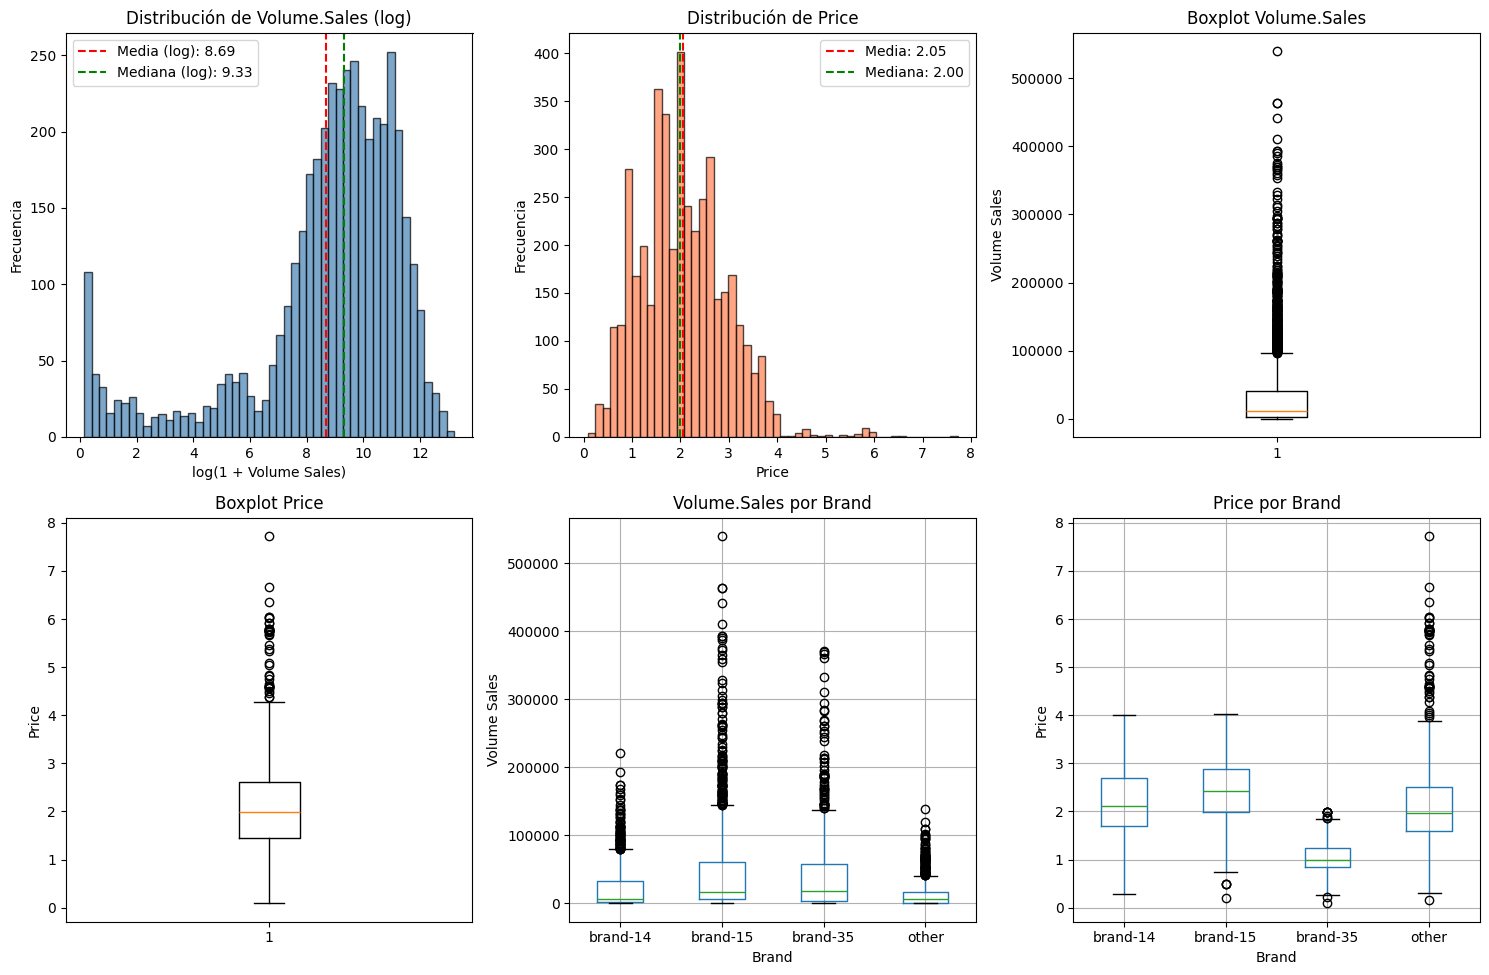


📊 DISTRIBUCIÓN POR CATEGORÍAS


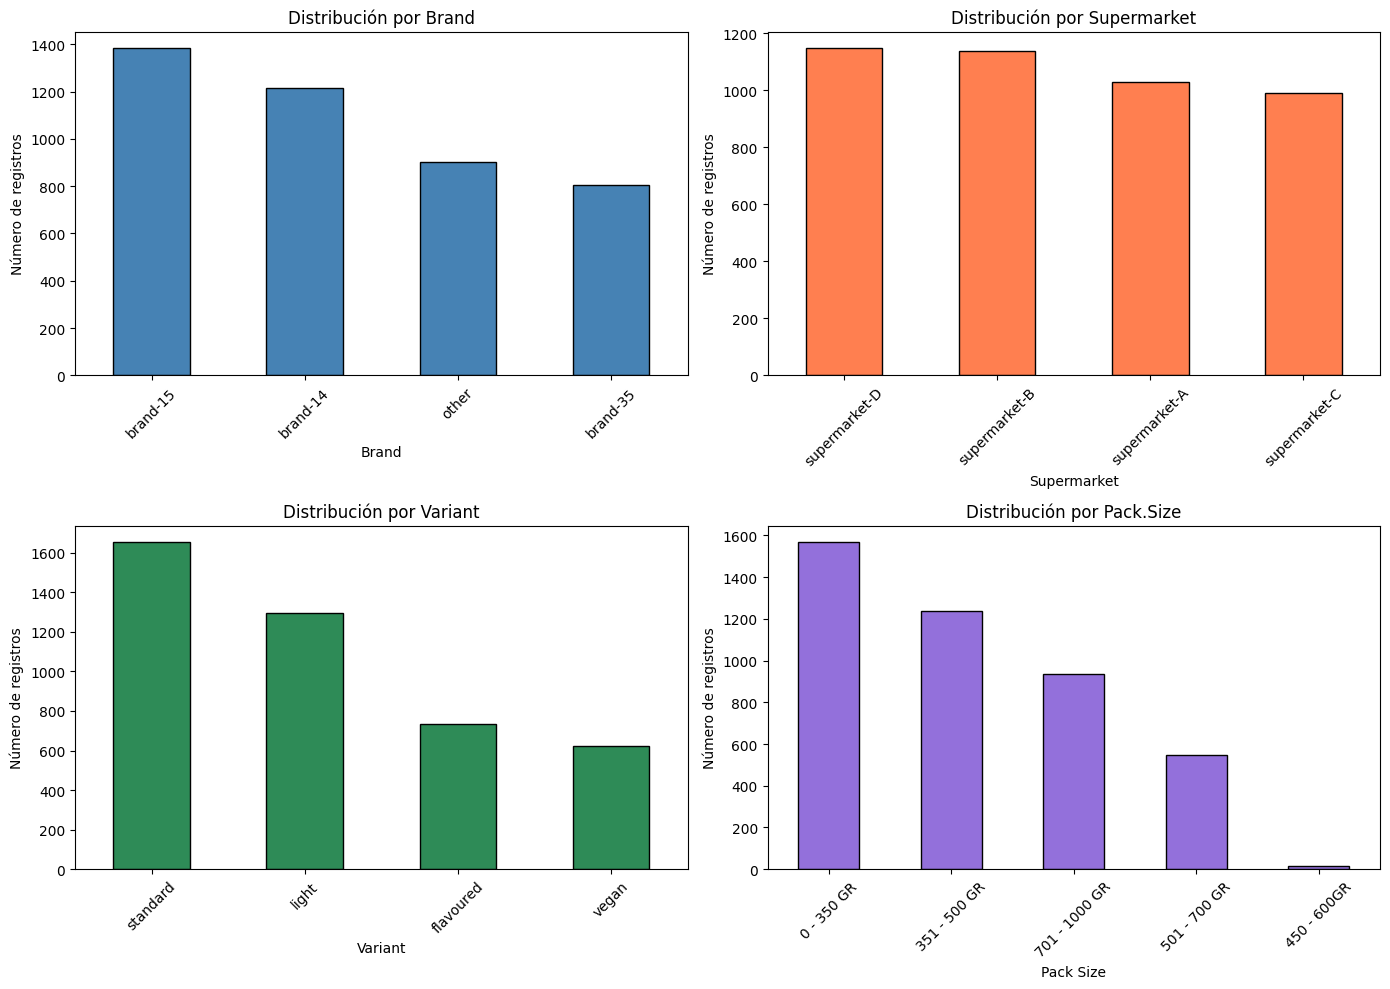


📊 CORRELACIÓN: VOLUME.SALES vs PRICE
Correlación de Pearson: 0.0319


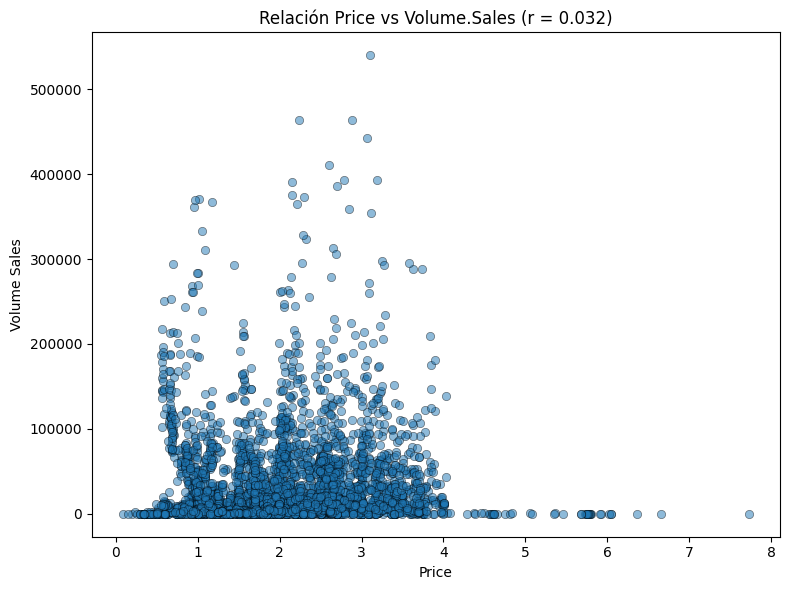

In [ ]:
def distributions_variables(data: pd.DataFrame):

    # Estadísticas descriptivas
    print("=" * 60)
    print("📊 ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS")
    print("=" * 60)
    print(data[['volume.sales', 'price']].describe())

    # Crear figura con subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Distribución de Variables', fontsize=14, fontweight='bold')

    # 1. Histograma de volume.sales en escala logarítmica (log de la variable)
    log_volume = np.log1p(data['volume.sales'])  # log(1 + x) para evitar log(0)
    # log_volume = data['volume.sales']
    ax1 = axes[0, 0]
    ax1.hist(log_volume, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.set_xlabel('log(1 + Volume Sales)')
    ax1.set_ylabel('Frecuencia')
    ax1.set_title('Distribución de Volume.Sales (log)')
    ax1.axvline(log_volume.mean(), color='red', linestyle='--', label=f'Media (log): {log_volume.mean():.2f}')
    ax1.axvline(log_volume.median(), color='green', linestyle='--', label=f'Mediana (log): {log_volume.median():.2f}')
    ax1.legend()

    # 2. Histograma de price
    ax2 = axes[0, 1]
    ax2.hist(data['price'], bins=50, edgecolor='black', alpha=0.7, color='coral')
    ax2.set_xlabel('Price')
    ax2.set_ylabel('Frecuencia')
    ax2.set_title('Distribución de Price')
    ax2.axvline(data['price'].mean(), color='red', linestyle='--', label=f'Media: {data["price"].mean():.2f}')
    ax2.axvline(data['price'].median(), color='green', linestyle='--', label=f'Mediana: {data["price"].median():.2f}')
    ax2.legend()

    # 3. Boxplot de volume.sales
    ax3 = axes[0, 2]
    ax3.boxplot(data['volume.sales'].dropna(), vert=True)
    ax3.set_ylabel('Volume Sales')
    ax3.set_title('Boxplot Volume.Sales')

    # 4. Boxplot de price
    ax4 = axes[1, 0]
    ax4.boxplot(data['price'].dropna(), vert=True)
    ax4.set_ylabel('Price')
    ax4.set_title('Boxplot Price')

    # 5. Volume.sales por brand
    ax5 = axes[1, 1]
    data.boxplot(column='volume.sales', by='brand', ax=ax5)
    ax5.set_xlabel('Brand')
    ax5.set_ylabel('Volume Sales')
    ax5.set_title('Volume.Sales por Brand')
    plt.suptitle('')  # Eliminar título automático

    # 6. Price por brand
    ax6 = axes[1, 2]
    data.boxplot(column='price', by='brand', ax=ax6)
    ax6.set_xlabel('Brand')
    ax6.set_ylabel('Price')
    ax6.set_title('Price por Brand')
    plt.suptitle('')

    plt.tight_layout()
    plt.show()

    # ============================================================
    # Distribución por categorías
    # ============================================================
    print("\n" + "=" * 60)
    print("📊 DISTRIBUCIÓN POR CATEGORÍAS")
    print("=" * 60)

    fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))

    # Conteo por brand
    ax_brand = axes2[0, 0]
    brand_counts = data['brand'].value_counts()
    brand_counts.plot(kind='bar', ax=ax_brand, color='steelblue', edgecolor='black')
    ax_brand.set_xlabel('Brand')
    ax_brand.set_ylabel('Número de registros')
    ax_brand.set_title('Distribución por Brand')
    ax_brand.tick_params(axis='x', rotation=45)

    # Conteo por supermarket
    ax_super = axes2[0, 1]
    super_counts = data['supermarket'].value_counts()
    super_counts.plot(kind='bar', ax=ax_super, color='coral', edgecolor='black')
    ax_super.set_xlabel('Supermarket')
    ax_super.set_ylabel('Número de registros')
    ax_super.set_title('Distribución por Supermarket')
    ax_super.tick_params(axis='x', rotation=45)

    # Conteo por variant
    ax_var = axes2[1, 0]
    var_counts = data['variant'].value_counts()
    var_counts.plot(kind='bar', ax=ax_var, color='seagreen', edgecolor='black')
    ax_var.set_xlabel('Variant')
    ax_var.set_ylabel('Número de registros')
    ax_var.set_title('Distribución por Variant')
    ax_var.tick_params(axis='x', rotation=45)

    # Conteo por pack.size
    ax_pack = axes2[1, 1]
    pack_counts = data['pack.size'].value_counts()
    pack_counts.plot(kind='bar', ax=ax_pack, color='mediumpurple', edgecolor='black')
    ax_pack.set_xlabel('Pack Size')
    ax_pack.set_ylabel('Número de registros')
    ax_pack.set_title('Distribución por Pack.Size')
    ax_pack.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # ============================================================
    # Correlación entre variables numéricas
    # ============================================================
    print("\n" + "=" * 60)
    print("📊 CORRELACIÓN: VOLUME.SALES vs PRICE")
    print("=" * 60)

    correlation = data['volume.sales'].corr(data['price'])
    print(f"Correlación de Pearson: {correlation:.4f}")

    fig3, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(data['price'], data['volume.sales'], alpha=0.5, edgecolors='black', linewidth=0.5)
    ax.set_xlabel('Price')
    ax.set_ylabel('Volume Sales')
    ax.set_title(f'Relación Price vs Volume.Sales (r = {correlation:.3f})')
    plt.tight_layout()
    plt.show()

TRANSFORMACIÓN BOX-COX

In [5]:
def boxcox_transform(y, warning=False):
    # ========== TRANSFORMACIÓN BOX-COX DE LA VARIABLE OBJETIVO ==========
    # Verificar que volume.sales sea positiva para aplicar Box-Cox

    # y = data['volume.sales'].copy() 

    if warning:
        print("📊 Verificación de datos para transformación Box-Cox:")
        print(f"   - Longitud de datos: {len(y)}")
        print(f"   - Valor mínimo: {y.min():.6f}")
        print(f"   - Valor máximo: {y.max():.6f}")
        print(f"   - Valores <= 0: {(y <= 0).sum()}")
        print(f"   - Media: {y.mean():.2f}")

    # Box-Cox requiere valores estrictamente positivos
    if (y <= 0).any():
        # Si hay ceros o negativos, necesitamos hacer un shift
        min_positive = y[y > 0].min() if (y > 0).any() else 1.0
        constant = max(1.0, min_positive)
        y_shifted = y + constant
        if warning:
            print(f"   ⚠️  Se detectaron valores <= 0. Aplicando shift: y + {constant:.6f}")
    else:
        y_shifted = y.copy()
        constant = 0.0
        if warning:
            print(f"   ✅ Todos los valores son positivos. No se requiere shift")

    # Aplicar transformación Box-Cox
    # scipy.stats.boxcox encuentra el lambda óptimo y aplica la transformación
    y_boxcox, lambda_optimal = stats.boxcox(y_shifted)

    if warning:
        print(f"\n📈 Estadísticas después de la transformación Box-Cox:")
        print(f"   - Lambda óptimo: {lambda_optimal:.6f}")
        print(f"   - Media Box-Cox: {y_boxcox.mean():.6f}")
        print(f"   - Desviación estándar Box-Cox: {y_boxcox.std():.6f}")
        print(f"   - Constante de shift aplicada: {constant:.6f}")

    # Guardar información de la transformación para reversión futura
    boxcox_transformation_info = {
        'type': 'boxcox',
        'lambda': lambda_optimal,
        'constant': constant
    }

    # Nota: Para revertir la transformación Box-Cox:
    # y_reversed = np.power(y_boxcox * lambda_optimal + 1, 1/lambda_optimal) - constant
    # Si lambda_optimal == 0, entonces: y_reversed = np.exp(y_boxcox) - constant
    return y_boxcox, boxcox_transformation_info
    
def inverse_boxcox(y_transformed, lambda_val: float, constant: float = 0.0):
    """
    Inversa de la transformación Box-Cox usada en `boxcox_transform`.

    Parameters
    ----------
    y_transformed : array-like
        Valores transformados
    lambda_val : float
        Lambda de Box-Cox
    constant : float
        Shift aplicado antes del Box-Cox (se resta al final)
    """
    y_transformed = np.asarray(y_transformed)
    if lambda_val == 0:
        return np.exp(y_transformed) - constant
    return np.power(y_transformed * lambda_val + 1, 1 / lambda_val) - constant

ELIMINAR SERIES CONFLICTIVAS DEL MODELO


In [6]:
if False:
    def remove_conflictive_series(
        df: pd.DataFrame,
        brand: str = None,
        supermarket: str = None,
        variant: str = None,
        pack_size: str = None,
        verbose: bool = True
    ) -> pd.DataFrame:
        """
        Elimina todas las filas del dataframe que coincidan con los valores especificados
        de brand, supermarket, variant y/o pack.size.
        
        La función elimina TODAS las combinaciones que incluyan los valores especificados.
        Por ejemplo, si pasas brand='brand-35' y supermarket='supermarket-A', eliminará
        TODAS las series que tengan esa brand Y ese supermarket, sin importar variant o pack.size.
        
        """
        df_clean = df.copy()
        
        # Crear máscara inicial (todas las filas)
        mask = pd.Series([True] * len(df_clean), index=df_clean.index)
        
        # Construir descripción del filtro
        filter_parts = []
        
        # Aplicar filtros según los parámetros proporcionados
        if brand is not None:
            mask &= (df_clean['brand'] == brand)
            filter_parts.append(f"brand='{brand}'")
        
        if supermarket is not None:
            mask &= (df_clean['supermarket'] == supermarket)
            filter_parts.append(f"supermarket='{supermarket}'")
        
        if variant is not None:
            mask &= (df_clean['variant'] == variant)
            filter_parts.append(f"variant='{variant}'")
        
        if pack_size is not None:
            mask &= (df_clean['pack.size'] == pack_size)
            filter_parts.append(f"pack.size='{pack_size}'")
        
        # Verificar que se haya especificado al menos un filtro
        if not filter_parts:
            if verbose:
                print("⚠️  No se especificó ningún filtro. No se eliminó ninguna fila.")
            return df_clean
        
        # Contar filas a eliminar
        rows_to_remove = mask.sum()
        
        if verbose:
            print("=" * 60)
            print("🗑️  ELIMINACIÓN DE SERIES CONFLICTIVAS")
            print("=" * 60)
            print(f"Filas iniciales: {len(df_clean):,}")
            print(f"Filtro aplicado: {' & '.join(filter_parts)}")
            print()
            
            if rows_to_remove > 0:
                # Obtener información adicional sobre lo que se elimina
                affected_series = df_clean[mask]
                
                print(f"📊 RESULTADOS:")
                print(f"   → Filas eliminadas: {rows_to_remove:,}")
            else:
                print("⚠️  No se encontraron filas que coincidan con el filtro especificado.")
            
            print("=" * 60)
        
        # Eliminar filas
        df_clean = df_clean[~mask]
        
        return df_clean

In [7]:
if False:
    conflictive_series_to_remove = [
        {"brand": "brand-14", "supermarket": "supermarket-A", "variant": "light","pack_size": "351 - 500 GR"},
        {"brand": "brand-14", "supermarket": "supermarket-A", "variant": "vegan", "pack_size": "701 - 1000 GR"},
        {"brand": "brand-14", "supermarket": "supermarket-B", "variant": "light", "pack_size": "351 - 500 GR"},

        {"brand": "brand-15", "supermarket": "supermarket-B", "variant": "light", "pack_size": "0 - 350 GR"},
        {"brand": "brand-15", "supermarket": "supermarket-C", "variant": "light", "pack_size": "0 - 350 GR"},

        {"brand": "brand-35", "supermarket": "supermarket-A", "variant": "light", "pack_size": "701 - 1000 GR"},
        {"brand": "brand-35", "supermarket": "supermarket-C", "variant": "light", "pack_size": "0 - 350 GR"},
        {"brand": "brand-35", "supermarket": "supermarket-D", "variant": "standard", "pack_size": "0 - 350 GR"},

    ]

    for filtro in conflictive_series_to_remove:
        data_clean = remove_conflictive_series(
            data_clean,
            brand=filtro.get("brand"),
            supermarket=filtro.get("supermarket"),
            variant=filtro.get("variant"),
            pack_size=filtro.get("pack_size"),
            verbose=True
        )


#### RUN preprocessing

In [ ]:
def run_preprocessing(ARIMA_model: bool = False):

    data_clean = clean_data(data)

    distributions_variables(data_clean)
    
    if ARIMA_model:
        filter_data = data_clean[   
            (data_clean["brand"] == "brand-35")
            & (data_clean["supermarket"] == "supermarket-A")
            & (data_clean["variant"] == "standard")
            & (data_clean["pack.size"] == "351 - 500 GR")
        ].copy()

        
    else:
        filter_data = None


    # Split train/test por tiempo (basado en fecha, no en índice)
    # Asegurar que date esté en formato datetime
    if ARIMA_model:
        filter_data = filter_data.copy()
        filter_data['date'] = pd.to_datetime(filter_data['date'])
        # Ordenar por fecha para asegurar orden temporal
        filter_data = filter_data.sort_values('date').reset_index(drop=True)
        
        # Calcular fecha de corte (80% del rango temporal)
        date_min = filter_data['date'].min()
        date_max = filter_data['date'].max()
        date_range = date_max - date_min
        train_cutoff = date_min + date_range * 0.8
        
        train_data = filter_data[filter_data['date'] <= train_cutoff].copy()
        test_data = filter_data[filter_data['date'] > train_cutoff].copy()
    else:
        # Trabajar con copia para no modificar el dataframe original
        data_work = data_clean.copy()
        data_work['date'] = pd.to_datetime(data_work['date'])
        # Ordenar por fecha para asegurar orden temporal
        data_work = data_work.sort_values('date').reset_index(drop=True)
        
        # Calcular fecha de corte (80% del rango temporal)
        date_min = data_work['date'].min()
        date_max = data_work['date'].max()
        date_range = date_max - date_min
        train_cutoff = date_min + date_range * 0.8
        
        train_data = data_work[data_work['date'] <= train_cutoff].copy()
        test_data = data_work[data_work['date'] > train_cutoff].copy()

    # Box-Cox: fit solo en train
    y_train_boxcox, boxcox_transformation_info = boxcox_transform(
        train_data["volume.sales"].copy()
    )

    # Aplicar misma transformación a test
    y_test = test_data["volume.sales"].copy()
    y_test_shifted = y_test + boxcox_transformation_info["constant"]

    if (y_test_shifted <= 0).any():
        raise ValueError(
            "Box-Cox requiere valores positivos. Tras aplicar el shift aprendido en train, "
            "test sigue teniendo valores <= 0. Revisa la serie o la estrategia de shift."
        )

    y_test_boxcox = stats.boxcox(
        y_test_shifted, lmbda=boxcox_transformation_info["lambda"]
    )

    return (
        data_clean,
        filter_data,
        train_data,
        test_data,
        y_train_boxcox,
        y_test_boxcox,
        boxcox_transformation_info,
    )